# Phase 2 Project

## Overview

A company that buys houses to flip and resell is interested in finding out what pre-existine features of houses are likely to lead to a higher sale price. Since they plan on "flipping" the house, or adding their own renovations, they aren't as interested in details such as the overall condition of the house and are more interested in things such as location, how big of a lot the house is built on, number of floors, whether the house uses a public or private sewer system, etc.

## Business Understanding

The features of the data from a housing dataset that I will be looking at, and comparing to the sale price of the houses, include number of bedrooms, number of bathrooms, square footage of the living area, square footage of the lot, number of floors, whether the house is on a waterfront, whether the house is adjacent to a green belt, whether the house has traffic noise or other nuisances, quality of the view of the house, type heat source and sewer system. 
After performing exploratory data analysis and determining which of these factors seem to relate to sale price, I will narrow down my efforts to determine which of those factors are the best predictors of sale price.

## Data Understanding

I begin by importing the necessary modules and the dataset I will be using, which includes housing data for King County.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
#import statsmodels.api as sm

In [4]:
data = pd.read_csv('Data/kc_house_data.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
1,8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
2,1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520
3,1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020
4,8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,...,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188


Next, I try to find out more about the data and narrow down the dataframe I will be using to only include the necessary columns.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

In [6]:
data = data[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view', 'heat_source', 'sewer_system']]
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,heat_source,sewer_system
0,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Gas,PUBLIC
1,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Oil,PUBLIC
2,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,AVERAGE,Gas,PUBLIC
3,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,AVERAGE,Gas,PUBLIC
4,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,NONE,Electricity,PUBLIC


In [7]:
data.corr()["price"]

price          1.000000
bedrooms       0.289204
bathrooms      0.480401
sqft_living    0.608521
sqft_lot       0.085730
floors         0.180576
Name: price, dtype: float64

Of the numeric variables in the data, it looks like the features most correlated with price are sqft_living, bathrooms, and bedrooms. The feature most correlated with price is sqft_living, so I will build a simple linear regression model of sqft_living vs. price as the baseline, intercept-only model to then compare other variables to.

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1010: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


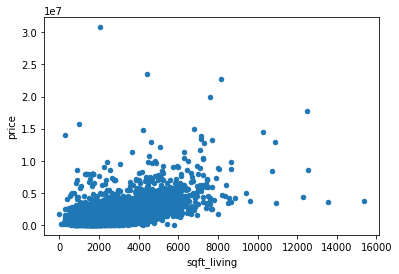

In [8]:
data.plot.scatter(x="sqft_living", y="price");

In [9]:
y = data[['price']]
X_baseline = data[['sqft_living']]

In [11]:
import statsmodels.api as sm

baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()

print(baseline_results.summary())

AttributeError: module 'numpy' has no attribute 'MachAr'

In [5]:
data_pred = data.iloc[:,1:11]
data_pred.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,heat_source
0,4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Gas
1,5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Oil
2,6,2.0,2880,6156,1.0,NO,NO,NO,AVERAGE,Gas
3,3,3.0,2160,1400,2.0,NO,NO,NO,AVERAGE,Gas
4,2,2.0,1120,758,2.0,NO,NO,YES,NONE,Electricity


Next, I begin investigating the variables in the dataset to determine which ones have a relationship with the target variable. I first create a model with price as the dependant variable and the other columns as the independant variables to get a better idea of which ones seem to have stronger relationships.

In [6]:
y = data[['price']]
X = data[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view', 'heat_source']]

In [10]:
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
results.summary

NameError: name 'sm' is not defined

## Data Preparation

## Modeling

## Regression Results

## Conclusion